In [3]:
%load_ext autoreload
%autoreload 2
    
import os, sys

os.environ['DYLD_LIBRARY_PATH']        = os.path.join(os.environ.get('CONDA_PREFIX',''), 'lib')
os.environ['DYLD_FALLBACK_LIBRARY_PATH'] = ''
#PWD = os.getenv('PWD')
PWD = '/Users/chris/Documents/lab/emAnalysis/backend/server'

PROJ_MISSING_MSG = """Set an enviroment variable:\n
`DJANGO_PROJECT=your_project_name`\n
or call:\n
`init_django(your_project_name)`
"""

def init_django(project_name=None):
    os.chdir(PWD)
    project_name = project_name or os.environ.get('DJANGO_PROJECT') or None
    if project_name == None:
        raise Exception(PROJ_MISSING_MSG)
    sys.path.insert(0, os.getenv('PWD'))
    os.environ.setdefault('DJANGO_SETTINGS_MODULE', f'{project_name}.settings')
    os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
    import django
    django.setup()

init_django("server")
from django.conf import settings
media_root = settings.MEDIA_ROOT
import numpy as np
import os
from matplotlib import pyplot as plt
import functools
import math
import sims
import copy
import cv2
import os
from pathlib import Path
import numpy as np
from skimage.measure import regionprops
from scipy import spatial
import pickle
from matplotlib.figure import Figure
import pyvips
from core.models import Canvas
from mims.models import MIMSImage, MIMSImageSet
from scipy.ndimage import rotate
import pprint
import sims
import SimpleITK as sitk
import tifffile

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from mims.services.register import register_images

# canvas_names = ["73_6hrfast_M1", "75_6hrfast_M2", "77_6hrfast_M3", "79_1hr13C_M1",
#                "81_1hr13C_M2_1", "81_1hr13C_M2_2", "83_1hr13C_M3", "85_ONfast_M1",
#                "87_ONfast_M2", "89_ONfast_M3"]
canvas_names = ["79_1hr13C_M1"]
roi_name = "79_mosaic7_1."
mims_to_register = None
for canvas_name in canvas_names:
    canvas = Canvas.objects.get(name=canvas_name)
    mims_images = MIMSImage.objects.filter(canvas=canvas)
    print([m.file.path for m in mims_images if roi_name in m.file.path])
    if roi_name:
        mims_images = [m for m in mims_images if roi_name in m.file.path]
    # Get the counts for each status and print with canvas name
    statuses = list(set([m.status for m in mims_images]))
    status_counts = {status: len([m for m in mims_images if m.status == status]) for status in statuses}
    print(canvas_name)
    print(status_counts)
    registering = [m for m in mims_images]
    
    for mims_image in registering:
        mims_to_register = mims_image
        mims_image.refresh_from_db()
        print("registering", mims_image.file.name)
        register_images(mims_image.id)

    
    

['/Users/chris/Documents/lab/emAnalysis/backend/server/media/mims_image_sets/a1b5db3c-b189-4bb1-8d0c-c4311a2b9b2a/mims_images/79_mosaic7_1.im']
79_1hr13C_M1
{'DEWARPED_ALIGNED': 1}
registering mims_image_sets/a1b5db3c-b189-4bb1-8d0c-c4311a2b9b2a/mims_images/79_mosaic7_1.im
/Users/chris/Documents/lab/emAnalysis/backend/server/media/mims_image_sets/a1b5db3c-b189-4bb1-8d0c-c4311a2b9b2a/mims_images/final/14N_12C_unwarped_OwBMRoH.png
/Users/chris/Documents/lab/emAnalysis/backend/server/media/mims_image_sets/a1b5db3c-b189-4bb1-8d0c-c4311a2b9b2a/mims_images/final/197Au_unwarped_xrT7lmd.png
/Users/chris/Documents/lab/emAnalysis/backend/server/media/mims_image_sets/a1b5db3c-b189-4bb1-8d0c-c4311a2b9b2a/mims_images/final/12C_unwarped_jkcobWx.png
/Users/chris/Documents/lab/emAnalysis/backend/server/media/mims_image_sets/a1b5db3c-b189-4bb1-8d0c-c4311a2b9b2a/mims_images/final/32S_unwarped_aMInnp6.png
/Users/chris/Documents/lab/emAnalysis/backend/server/media/mims_image_sets/a1b5db3c-b189-4bb1-8d0c-c

In [5]:
from mims.models import MIMSImage, MIMSImageSet
from image.models import Image
from PIL import Image as PILImage
for canvas in Canvas.objects.all():
  # get the images from a canvas through related field
  if hasattr(canvas, "images"):
    print(canvas.name)
    try:
      img = PILImage.open(canvas.images.first().file.path)
      canvas.shape = [img.size[0], img.size[1]]
      canvas.width = img.size[0]
      canvas.height = img.size[1]
      canvas.save()
    except Exception as e:
      pass


Wortham 1035-1
Wortham 1035-3
Wortham 1036-1
wortham 1036-2
wortham 1037-r2
wortham 1037-r3
wortham 1037-r4
wortham 1037-4
wortham 1038-1
wortham 1038-2
wortham 1038-3
wortham 1038-4
951
ImmunoEM-test
Pump Test 1 - HFD 6-8wk
Pump Test 2 - HFD 4-8wk
Pump Test 3 - CD 6-8wk
Pump CD M1-1
Pump CD M3
Pump HFD M1-1
Pump HFD M2
Pump HFD M3
Pump CD M2
Glutamine 1hr
Glutamine 4hr
NMJ Region 5
673
674_2
674_1
677_2
677_1
681
683
73_6hrfast_M1
75_6hrfast_M2
77_6hrfast_M3
79_1hr13C_M1
81_1hr13C_M2_1
81_1hr13C_M2_2
83_1hr13C_M3
85_ONfast_M1
87_ONfast_M2
89_ONfast_M3


In [8]:
import time
import numpy as np
import matplotlib.pyplot as plt
from mims.services.image_utils import image_from_im_file
from mims.services.registration_utils import radial_spokes
from mims.services.register import (
    validate_mims_image,
    get_points_transform,
    get_mims_dims,
    polygon_centroid,
)
from skimage.transform import SimilarityTransform, ThinPlateSplineTransform, warp
from skimage.draw import disk
import pandas as pd
from PIL import Image


def _flip_x(arr, max_x):
    arr = np.asarray(arr, float).copy()
    if arr.ndim == 1:
        arr[0] = max_x - arr[0]
    else:
        arr[:, 0] = max_x - arr[:, 0]
    return arr
def register_images2(mims_image_obj_id):
    """
    1) Optional X-mirror of MIMS landmarks (same axis get_points_transform used)
    2) Similarity affine             →  EM_pred
    3) Median-offset tweak on translation
    4) Thin-plate spline on residuals (EM_pred → EM_true)
    5) Build inverse warp maps + canvas_bbox
    6) Display diagnostic plots (TPS panel now uses skimage.transform.warp)
    """
    start_time = time.time()

    # ---------- 0. objects & basic geometry ------------------------
    mims_img, em_shapes, mims_shapes, em_pts, mims_pts = validate_mims_image(
        mims_image_obj_id
    )
    h_mims, w_mims = get_mims_dims(mims_img)

    # ---------- 1. coarse similarity (with optional mirror) --------
    em_cent = [polygon_centroid(e) for e in em_shapes] + em_pts
    mims_cent = [polygon_centroid(m) for m in mims_shapes] + mims_pts

    base_tf, needs_flip, max_x = get_points_transform(
        mims_img.image_set,
        np.asarray(mims_cent, float),
        np.asarray(em_cent, float),
    )

    if needs_flip:
        mims_shapes = [_flip_x(s, max_x) for s in mims_shapes]
        mims_pts = [_flip_x(p, max_x) for p in mims_pts]

    # ---------- 2. landmark arrays after affine --------------------
    mims_stack, em_stack = np.empty((0, 2)), np.empty((0, 2))
    for mp, ep in zip(mims_shapes, em_shapes):
        mims_stack = np.vstack([mims_stack, polygon_centroid(mp)])
        em_stack = np.vstack([em_stack, polygon_centroid(ep)])
    for mp, ep in zip(mims_pts, em_pts):
        mims_stack = np.vstack([mims_stack, mp])
        em_stack = np.vstack([em_stack, ep])

    #   2a. Initial affine prediction --------------------------------------
    mims_pred = base_tf(mims_stack.copy())

    # ---------- 3. median offset tweak -----------------------------
    delta = mims_pred - em_stack
    offset = np.median(delta, axis=0)
    mims_tf = SimilarityTransform(
        scale=1, rotation=base_tf.rotation, translation=[0, 0]
    )
    em_tf = SimilarityTransform(scale=1/base_tf.scale, translation=-(base_tf.translation - offset)/base_tf.scale)

    #   add image corners so the TPS controls the entire canvas -----
    mims_corners = np.array(
        [[0, 0], [w_mims - 1, 0], [w_mims - 1, h_mims - 1], [0, h_mims - 1]],
        dtype=float,
    )
    if needs_flip:
        mims_corners = _flip_x(mims_corners, max_x)
    em_corners = mims_tf(mims_corners)
    min_xy = np.min(em_corners, axis=0)
    max_xy = np.max(em_corners, axis=0)
    shift = -np.minimum(min_xy, 0)  
    if (shift > 0).any():
        # rebuild the two similarity transforms **with the shift added**
        mims_tf = SimilarityTransform(
            scale    = 1,
            rotation = base_tf.rotation,
            translation = shift                   # <-- NEW
        )

        em_tf = SimilarityTransform(
            scale       = 1 / base_tf.scale,
            translation = (                     # original → plus the same shift
                -(base_tf.translation - offset) / base_tf.scale + shift
            )
        )
    em_corners = mims_tf(mims_corners)

    mims_pred = mims_tf(mims_stack)
    em_pred = em_tf(em_stack)

    mims_pred = np.vstack([mims_pred, em_corners])
    em_pred = np.vstack([em_pred, em_corners])


    # ---------- 4. thin-plate spline fit ---------------------------
    tps = ThinPlateSplineTransform()
    # NOTE: we pass (dst, src) so that `tps` is the **inverse** map,
    #       exactly what `skimage.transform.warp` expects
    tps.estimate(em_pred, mims_pred)
    tps_inv = ThinPlateSplineTransform()
    tps_inv.estimate(mims_pred, em_pred)

    # ---------- 5. Load and test on an image
    raw = image_from_im_file(mims_img.file.path, "SE", autocontrast=False)
    if needs_flip:
        raw = raw[:, ::-1]
    output_shape = [int(max_xy[1] - min_xy[1]), int(max_xy[0] - min_xy[0])]
    
    raw2 = warp(raw, mims_tf.inverse, output_shape=output_shape)
    raw3 = warp(
        raw2,
        tps,
        output_shape=output_shape
    )

    # ---------- 6. Get the EM BBOX ------------------------------
    canvas_corners = mims_tf(mims_corners)
    em_corners = em_tf.inverse(canvas_corners)
    x0, y0 = np.floor(em_corners.min(axis=0)).astype(int)
    x1, y1 = np.ceil (em_corners.max(axis=0)).astype(int)

    # clamp to the EM image limits (in case any indices went slightly <0 or >size-1)
    em_img = np.array(Image.open(mims_img.canvas.images.first().file.path))
    H, W  = em_img.shape[:2]
    x0, x1 = np.clip([x0, x1], 0, W)
    y0, y1 = np.clip([y0, y1], 0, H)

    # finally crop
    em_cropped = em_img[y0:y1, x0:x1]
    

    # ---------- 7. diagnostics ------------------------------------
    fig, axes = plt.subplots(2,3, figsize=(18, 10))
    titles = [
        "EM landmarks",
        "MIMS→EM (raw)",
        "Overlay (raw)",
        "MIMS→EM (TPS via warp)",
    ]

    # (0) EM landmarks
    axes[0,0].scatter(em_pred[:, 0], em_pred[:, 1], c="lime", marker="x", s=12)

    # (1) affine prediction
    axes[0,1].scatter(
        mims_pred[:, 0],
        mims_pred[:, 1],
        edgecolors="magenta",
        facecolors="none",
        marker="o",
        s=12,
    )

    # (2) raw overlay
    axes[0,2].scatter(
        em_pred[:, 0], em_pred[:, 1], c="lime", marker="x", s=12, label="EM"
    )
    axes[0,2].scatter(
        mims_pred[:, 0],
        mims_pred[:, 1],
        edgecolors="magenta",
        facecolors="none",
        marker="o",
        s=12,
        label="MIMS pred",
    )
    # TPS Row Panels
    tps_mims_pts = tps_inv(mims_pred)
    axes[1,0].scatter(
        tps_mims_pts[:, 0],
        tps_mims_pts[:, 1],
        edgecolors="magenta",
        facecolors="none",
        marker="o",
        s=12,
        label="TPS MIMS",
    )
    # overlay the EM ground-truth for reference
    axes[1,0].scatter(
        em_pred[:, 0], em_pred[:, 1], c="lime", marker="x", s=12, label="EM"
    )

    axes[1,1].imshow(
        em_cropped,
        cmap="magma",
        interpolation="nearest",
    )
    axes[1,2].imshow(
        cv2.resize(raw3, (em_cropped.shape[1], em_cropped.shape[0])),
        cmap="magma",
        interpolation="nearest",
    )

    # common cosmetics
    for ax, title in zip(axes.flatten(), titles):
        ax.set_title(title)
        ax.set_aspect("equal", adjustable="box")
        ax.invert_yaxis()
        ax.grid(True)
        if "Overlay" in title or "TPS" in title:
            ax.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

    print(f"Finished in {time.time() - start_time:.2f} s")


mims_corners [[511.   0.]
 [  0.   0.]
 [  0. 511.]
 [511. 511.]]
[[469.31921171 671.45895921]
 [671.45895921 202.13974749]
 [202.13974749   0.        ]
 [  0.         469.31921171]]
[[37491.71314794 24152.91161705]
 [40631.13920691 16863.92970474]
 [33342.1572946  13724.50364577]
 [30202.73123563 21013.48555809]]
30202 40632 13724 24153 True
32629 64640


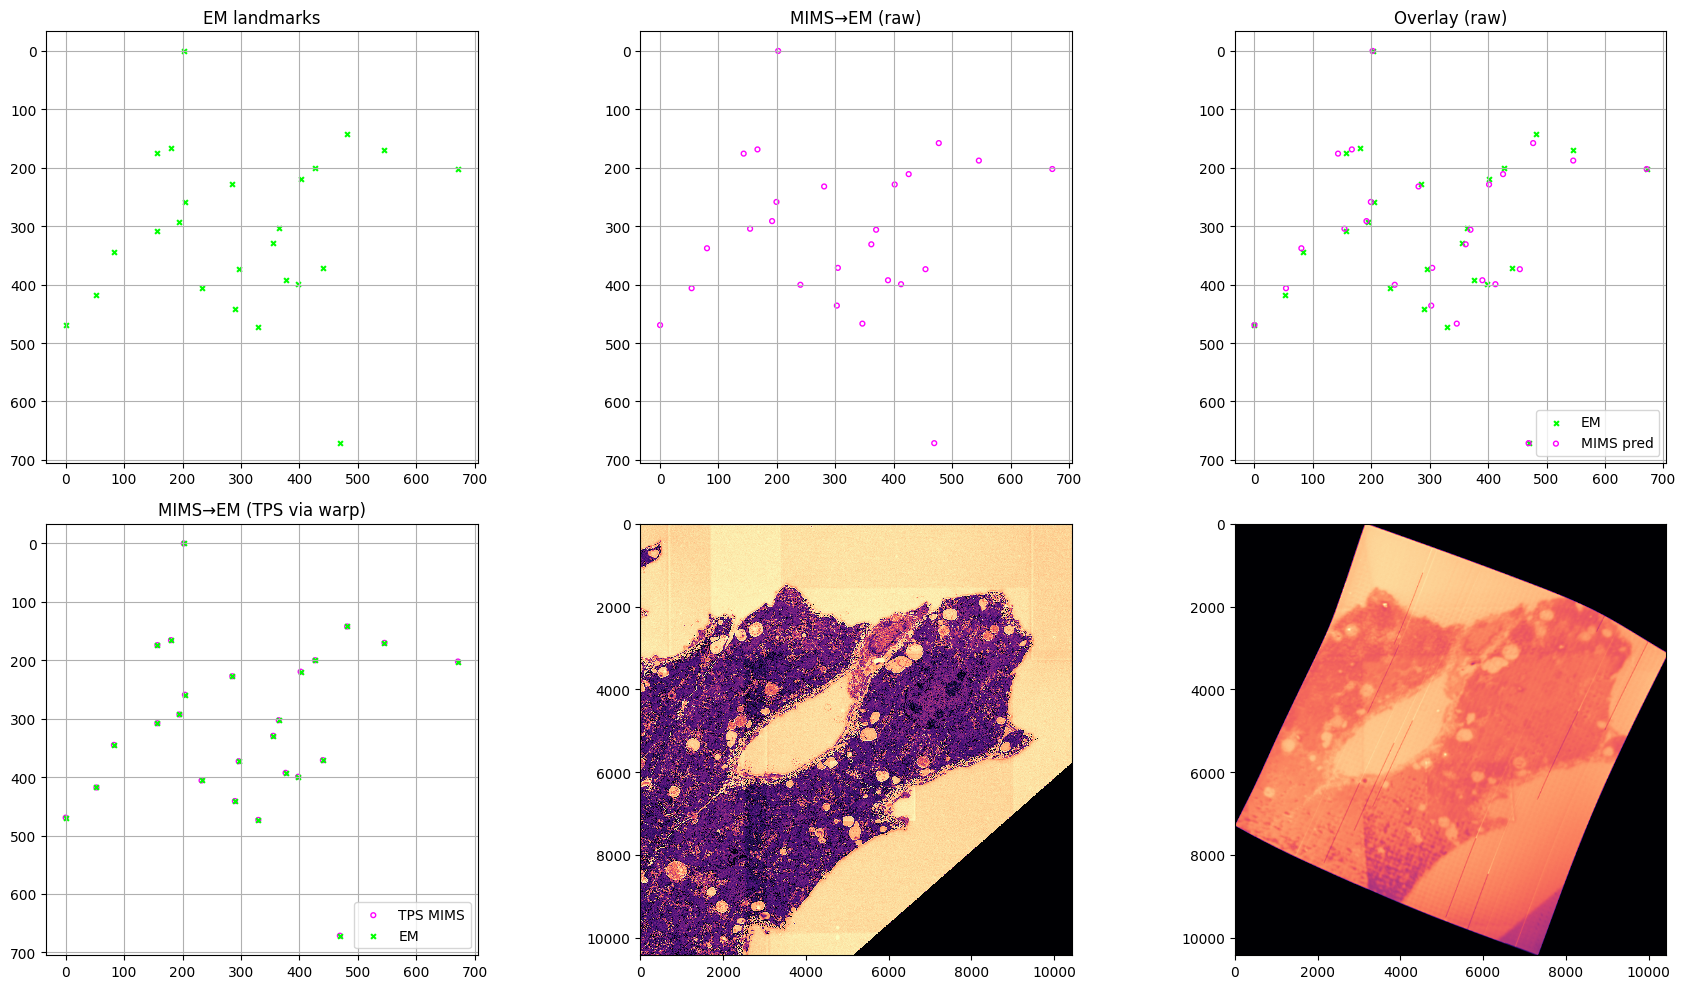

Finished in 8.97 s


In [11]:
register_images2("6ab0c78c-d006-4438-84da-e1b8ccbbd0ab")


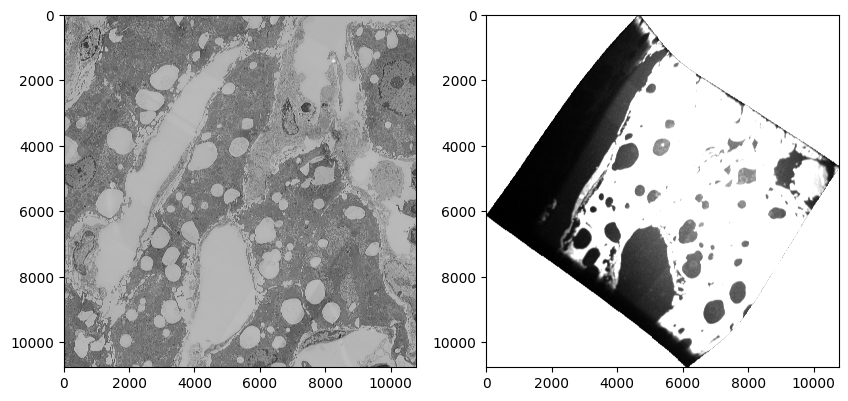

In [13]:
from mims.models import MIMSImage
from PIL import Image as PILImage
mims = MIMSImage.objects.get(id="65657e40-868a-4186-b57a-5a3d51ab1552")
se_tiff = mims.mims_tiff_images.filter(name__contains="14N").first()
em = PILImage.open(mims.canvas.images.first().file.path)
semims = PILImage.open(se_tiff.image.path)
bbox = se_tiff.registration_bbox
minx = min([b[0] for b in bbox])
miny = min([b[1] for b in bbox])
maxx = max([b[0] for b in bbox])
maxy = max([b[1] for b in bbox])
em = em.crop((minx, miny, maxx, maxy))
#plot the em cropped and semims side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(em, cmap="gray")
ax[1].imshow(semims, cmap="gray")
plt.show()
